In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from StrongFieldIonizer import StrongFieldIonizer, write_sfi_results, load_sfi_results
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm

In [2]:
# setup simulation and k-space
sim = StrongFieldIonizer()
sim.epsilon = 1
sim.t_start = 0.0
sim.t_end   = sim.T
sim.N_time  = 1000
sim.Nc = 1

Up = sim.Up
threshold = 2.0 * np.sqrt(Up)
k_range = [ -threshold, threshold ]
N_ks    = 300

k_ys, k_zs = sim.get_k_space(k_range, N_ks)
Z, Y = np.meshgrid(k_ys, k_zs)

# sweep of values
nc_values = np.arange(1, 11)

all_A_ts = []
all_matrices = []

# run simulations
for nc in tqdm(nc_values) : 
    sim.Nc = nc
    A_ts, _, _, matrix = sim.calculate_matrix_elements(k_range=k_range, N_ks=N_ks, progress_bar=False)

    all_A_ts.append(A_ts)
    all_matrices.append(matrix)
    

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


In [5]:
write_sfi_results(outfname="./Animations/sfi_results_nc_circular.txt.gz", simulator=sim, k_range=k_range, N_ks=N_ks, parameters=nc_values, all_A_ts=all_A_ts, all_matrices=all_matrices)

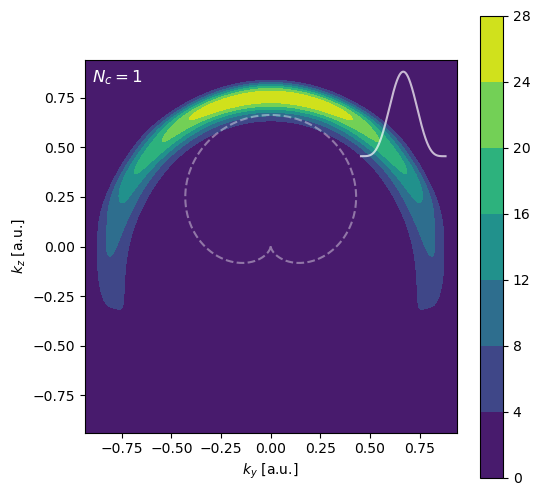

In [4]:
fig = plt.figure(figsize=(6,6))

def update(i):
    # clear the whole figure
    fig.clear()

    # retrieve simulation results
    A_ts = all_A_ts[i]
    A_ys, A_zs = -A_ts[1], -A_ts[2]
    A2 = np.sum(A_ts**2, axis=0)
    matrix = all_matrices[i]

    # do all the plotting
    ax = fig.add_subplot(1,1,1)
    cf = ax.contourf(Y, Z, matrix)
    ax.plot(A_ys, A_zs, 'w--', alpha=0.4)

    ax.set_xlabel("$k_y$ [a.u.]")
    ax.set_ylabel("$k_z$ [a.u.]")
    ax.set_aspect('equal')

    fig.colorbar(cf, ax=ax)

    # text label
    ax.text(
        0.02, 0.98,               
        rf"$N_c = ${nc_values[i]}",
        transform=ax.transAxes,    
        color='white',             
        va='top', ha='left',       
        fontsize=12                
    )

    # make inset plot
    iax = inset_axes(ax, width="25%", height="25%", loc='upper right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes)
    # plot envelope profile
    iax.plot(np.arange(len(A2)), A2, color='white', alpha=0.7)
    # make transparent
    iax.set_facecolor((0,0,0,0))
    # remove borders
    for spine in iax.spines.values(): spine.set_visible(False)
    # remove ticks
    iax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


ani = FuncAnimation(fig, update,
                    frames=len(nc_values),
                    interval=800,   # ms between frames
                    blit=False)

writer = PillowWriter(fps=5)
ani.save("./Animations/sfi_nc_sweep_circular.gif", writer=writer)